In [1]:
import csv
import time
import random
import requests
from lxml import etree
import pandas as pd
import numpy as np

In [2]:
yelp = pd.read_csv('yelp.csv')

In [3]:
yelp = yelp.drop(columns=['Unnamed: 0'])
yelp.columns

Index(['city', 'restaurant', 'rank', 'point', 'review_n', 'username',
       'location', 'has_profile', 'friend', 'review', 'photo', 'text', 'date',
       'rating', 'fake', 'local', 'compound', 'positive', 'negative',
       'neutral', 'word_count', 'sentence_length', 'adj_POS', 'I_pronoun',
       'past_tense', 'rating_dev', 'ttr', 'verb_POS', 'pron_POS', 'adv_POS',
       'prep_POS', 'conj_POS'],
      dtype='object')

In [4]:
yelp.shape

(486756, 32)

In [5]:
table = yelp.head()
display(table)

,city,restaurant,rank,point,review_n,username,location,has_profile,friend,review,...,compound,positive,negative,neutral,word_count,sentence_length,adj_POS,I_pronoun,past_tense,rating_dev
0,Alameda,Jong Ga House,236,4.0,2300.0,Ernesto B.,"Oakland, CA",0.0,0.0,1.0,...,0.9618,0.583,0.000,0.417,20,4,0.200000,0.000000,0.000000,0.843328
1,Alameda,Jong Ga House,236,4.0,2300.0,Katrina F.,"San Francisco, CA",1.0,914.0,101.0,...,0.9889,0.141,0.056,0.803,364,17,0.076923,0.016484,0.035714,0.843328
2,Alameda,Jong Ga House,236,4.0,2300.0,Mario V.,"San Francisco, CA",1.0,86.0,13.0,...,0.9059,0.074,0.053,0.874,544,46,0.082721,0.022059,0.031250,-2.529983
3,Alameda,Jong Ga House,236,4.0,2300.0,Giselle A.,"Martinez, CA",1.0,240.0,15.0,...,0.9716,0.224,0.018,0.758,98,9,0.132653,0.030612,0.000000,0.843328
4,Alameda,Jong Ga House,236,4.0,2300.0,Seth E.,"Dublin, CA",1.0,249.0,40.0,...,0.7708,0.075,0.051,0.874,178,11,0.078652,0.005618,0.028090,0.000000


# text data cleaning

In [5]:
import re
import html

def remove_non_ascii(text):
    # 先解码 HTML 实体编码，然后再去除非 ASCII 字符
    text = html.unescape(str(text))
    return re.sub(r'[^\x00-\x7F]+', '', text)

# 在应用函数之前，确保 'text' 列中的所有值都是字符串
yelp['text'] = yelp['text'].apply(remove_non_ascii)

In [6]:
from bs4 import BeautifulSoup

def clean_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text()
    return cleaned_text

yelp['text'] = yelp['text'].apply(clean_text)

C:\Users\10047\AppData\Local\Temp\ipykernel_8380\1508285557.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\10047\AppData\Local\Temp\ipykernel_8380\1508285557.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


# text derived variables

sentiment

In [8]:
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [9]:
analyzer = SentimentIntensityAnalyzer()

yelp['positive'] = yelp['text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
yelp['negative'] = yelp['text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
yelp['neutral'] = yelp['text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])

richness

In [6]:
yelp['word_count'] = yelp['text'].apply(lambda x: len(x.split()))

In [9]:
yelp['sentence_length'] = yelp['text'].apply(lambda x: len(x.split('.')))

In [10]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.corpus import stopwords

def calculate_ttr(text):
    tokens = word_tokenize(text)
    if len(tokens) > 0:
        types = set(tokens)
        ttr = len(types) / len(tokens)
        return ttr
    else:
        return 0.0

yelp['ttr'] = yelp['text'].apply(calculate_ttr)

POS

In [16]:
pip install nltk

In [7]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10047\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def individual_adjective_frequency(text_column):
    adjective_frequencies = []
    
    for text in text_column:
        words = word_tokenize(text)
        tagged_words = pos_tag(words)
        
        # 提取形容词
        adjectives = [word for word, pos in tagged_words if pos.startswith('JJ')]
        
        # 计算形容词词频
        adjective_freq = len(adjectives)
        
        adjective_frequencies.append(adjective_freq)
    
    return adjective_frequencies

yelp['adj_POS'] = individual_adjective_frequency(yelp['text'])

In [10]:
yelp['adj_POS'] =  yelp['adj_POS']/ yelp['word_count']

In [11]:
description =yelp[['verb_POS', 'pron_POS', 'adv_POS','prep_POS', 'conj_POS','adj_POS']].describe()
display(description)

,verb_POS,pron_POS,adv_POS,prep_POS,conj_POS,adj_POS
count,486754.000000,486754.000000,486754.000000,486754.000000,486754.000000,486754.000000
mean,0.182609,0.082782,0.081917,0.083438,0.051561,0.113738
std,0.052659,0.045426,0.046449,0.039406,0.032003,0.056699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.156250,0.053571,0.054217,0.060241,0.035088,0.080000
50%,0.185185,0.083333,0.077778,0.086420,0.050000,0.105263
75%,0.212766,0.111111,0.104651,0.108225,0.066667,0.137255
max,1.000000,1.000000,2.000000,1.000000,7.400000,1.000000


In [10]:
from nltk import word_tokenize, pos_tag
import pandas as pd

def individual_pos_frequency(text_column, pos_tag_prefix):
    frequencies = []
    
    for text in text_column:
        words = word_tokenize(text)
        tagged_words = pos_tag(words)
        
        # 提取特定词性的词汇
        pos_words = [word for word, pos in tagged_words if pos.startswith(pos_tag_prefix)]
        
        # 计算词频
        freq = len(pos_words)
        
        frequencies.append(freq)
    
    return frequencies

# 在数据集中创建新的变量存储不同词性的词频
yelp['verb_POS'] = individual_pos_frequency(yelp['text'], 'VB')  # 动词
yelp['pron_POS'] = individual_pos_frequency(yelp['text'], 'PRP')  # 代词
yelp['adv_POS'] = individual_pos_frequency(yelp['text'], 'RB')  # 副词
yelp['prep_POS'] = individual_pos_frequency(yelp['text'], 'IN')  # 介词
yelp['conj_POS'] = individual_pos_frequency(yelp['text'], 'CC')  # 连词

In [11]:
yelp['verb_POS'] =  yelp['verb_POS']/ yelp['word_count']
yelp['pron_POS'] =  yelp['pron_POS']/ yelp['word_count']
yelp['adv_POS'] =  yelp['adv_POS']/ yelp['word_count']
yelp['prep_POS'] =  yelp['prep_POS']/ yelp['word_count']
yelp['conj_POS'] =  yelp['conj_POS']/ yelp['word_count']

pronoun

In [7]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10047\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
print(yelp['text'].dtype)

object


In [8]:
yelp['text'] = yelp['text'].astype(str)

In [18]:
def count_first_person_singular_pronouns(text):
    # 分词
    words = word_tokenize(text)
    
    # 提取第一人称单数代词（I, me, my, mine, myself）
    first_person_singular_pronouns = ['i', 'me', 'my', 'mine', 'myself']
    
    # 统计第一人称单数代词的次数
    counts = Counter(word.lower() for word in words if word.lower() in first_person_singular_pronouns)
    
    # 返回次数
    return counts['i'] + counts['me'] + counts['my'] + counts['mine'] + counts['myself']

yelp['I_pronoun'] = yelp['text'].apply(count_first_person_singular_pronouns)

In [19]:
yelp['I_pronoun'] =  yelp['I_pronoun']/ yelp['word_count']

In [9]:
def count_person_singular_pronouns(text, pronouns):
    # 分词
    words = word_tokenize(text)
    
    # 统计指定人称单数代词的次数
    counts = Counter(word.lower() for word in words if word.lower() in pronouns)
    
    # 返回次数
    return sum(counts[pronoun] for pronoun in pronouns)

# 第二人称单数代词（you, your, yours, yourself）
second_person_singular_pronouns = ['you', 'your', 'yours', 'yourself']
yelp['you_pronoun'] = yelp['text'].apply(lambda x: count_person_singular_pronouns(x, second_person_singular_pronouns))

# 第三人称单数代词（he, him, his, she, her, hers, it, its, itself）
third_person_singular_pronouns = ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'itself']
yelp['3rd_pronoun'] = yelp['text'].apply(lambda x: count_person_singular_pronouns(x, third_person_singular_pronouns))

In [10]:
yelp['you_pronoun'] =  yelp['you_pronoun']/ yelp['word_count']
yelp['3rd_pronoun'] =  yelp['3rd_pronoun']/ yelp['word_count']

tense

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [12]:
yelp['text'] = yelp['text'].astype(str)

In [22]:
def get_total_past_tense_frequency(text):
    # 分词
    words = word_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    # 提取过去式动词
    past_tense_verbs = [word for (word, pos) in nltk.pos_tag(words) if pos.startswith('VBD')]
    
    # 计算过去式动词的总数
    total_count = len(past_tense_verbs)
    
    return total_count

In [23]:
yelp['past_tense'] = yelp['text'].apply(get_total_past_tense_frequency)

In [24]:
yelp['past_tense'] =  yelp['past_tense']/ yelp['word_count']

In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from collections import Counter

# 需要下载 'averaged_perceptron_tagger' 数据
nltk.download('averaged_perceptron_tagger')

def get_tense_frequency(text, tense_tags):
    # 分词
    words = word_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    # 提取指定时态的动词
    tense_verbs = [word for (word, pos) in nltk.pos_tag(words) if pos in tense_tags]
    
    # 计算指定时态动词的总数
    total_count = len(tense_verbs)
    return total_count

# 现在时动词（VB, VBP）
present_tense_tags = ['VB', 'VBP']
yelp['present_tense'] = yelp['text'].apply(lambda x: get_tense_frequency(x, present_tense_tags))

# 将来时动词（MD, VB）
future_tense_tags = ['MD', 'VB']
yelp['future_tense'] = yelp['text'].apply(lambda x: get_tense_frequency(x, future_tense_tags))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\10047\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
yelp['present_tense'] =  yelp['present_tense']/ yelp['word_count']
yelp['future_tense'] =  yelp['future_tense']/ yelp['word_count']

rating_dev

In [25]:
# 根据 'City' 和 'Restaurant' 分组，计算每个餐厅的方差
restaurant_variance = yelp.groupby(['city', 'restaurant'])[['rating', 'point']].var().reset_index()

In [26]:
table = restaurant_variance.head()
display(table)

,city,restaurant,rating,point
0,Alameda,Aman Cafe,0.394203,0.0
1,Alameda,Brendas Oakland,1.843239,0.0
2,Alameda,Cholita Linda,1.049285,0.0
3,Alameda,Cinema Grill,2.113233,0.0
4,Alameda,East End,2.048766,0.0


In [8]:
restaurant_variance.shape

(749, 4)

In [27]:
restaurant_variance['Variance'] = restaurant_variance['rating'] + restaurant_variance['point']

In [28]:
restaurant_variance = restaurant_variance.drop(columns=['rating'])
restaurant_variance = restaurant_variance.drop(columns=['point'])

In [29]:
# 合并 restaurant_variance 到 yelp 数据集，基于 'City' 和 'Restaurant' 列
yelp = yelp.merge(restaurant_variance, on=['city', 'restaurant'], how='left')

In [30]:
# 计算'Rating_dev'，并存储在新的列中
yelp['rating_dev'] = (yelp['rating'] - yelp['point']) / yelp['Variance']

In [31]:
yelp['rating_dev'] = yelp['rating_dev'].replace([np.inf, -np.inf], 0)

In [32]:
yelp = yelp.drop(columns=['Variance'])

In [33]:
yelp.columns

Index(['city', 'restaurant', 'rank', 'point', 'review_n', 'username',
       'location', 'has_profile', 'friend', 'review', 'photo', 'text', 'date',
       'rating', 'fake', 'local', 'compound', 'positive', 'negative',
       'neutral', 'word_count', 'sentence_length', 'adj_POS', 'I_pronoun',
       'past_tense', 'rating_dev'],
      dtype='object')

In [44]:
yelp = yelp.fillna(0)

In [15]:
yelp.to_csv('yelp.csv')

# 可视化

In [36]:
restaurant = yelp[['city', 'restaurant', 'rank', 'point', 'review_n', 'fake']]

In [37]:
user = yelp[['username','location', 'has_profile', 'friend', 'review', 'photo','rating', 'rating_dev','local', 'fake']]

In [38]:
reviews = yelp[[ 'text', 'date', 'compound', 'positive', 
                'negative', 'neutral', 'word_count', 'sentence_length',
                'adj_POS', 'I_pronoun', 'past_tense', 'fake']]

In [39]:
description = restaurant.describe()
display(description)

,rank,point,review_n,fake
count,486756.000000,486756.000000,486756.000000,486754.000000
mean,143.747537,4.031845,2937.456167,0.099239
std,77.080144,0.364731,4375.892896,0.298983
min,8.000000,1.000000,1.000000,0.000000
25%,49.000000,3.900000,686.000000,0.000000
50%,170.000000,4.100000,1400.000000,0.000000
75%,201.000000,4.300000,2900.000000,0.000000
max,239.000000,5.000000,18400.000000,1.000000


In [9]:
target_value = 18400
target_individuals = restaurant[restaurant['review_n'] == target_value]

# 如果有多个个体具有'review_n'等于18400的情况，您可以打印它们的信息
if not target_individuals.empty:
    print("Individuals with 'review_n' equal to 18400:")
    print(target_individuals)
else:
    print("No individuals with 'review_n' equal to 18400 found.")

Individuals with 'review_n' equal to 18400:
               city     restaurant  rank  point  review_n  fake
207339  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
207340  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
207341  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
207342  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
207343  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
...             ...            ...   ...    ...       ...   ...
222500  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
222501  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
222502  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
222503  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0
222504  Los Angeles  Bottega Louie    27    4.1   18400.0   0.0

[15166 rows x 6 columns]


pip install matplotlib seaborn

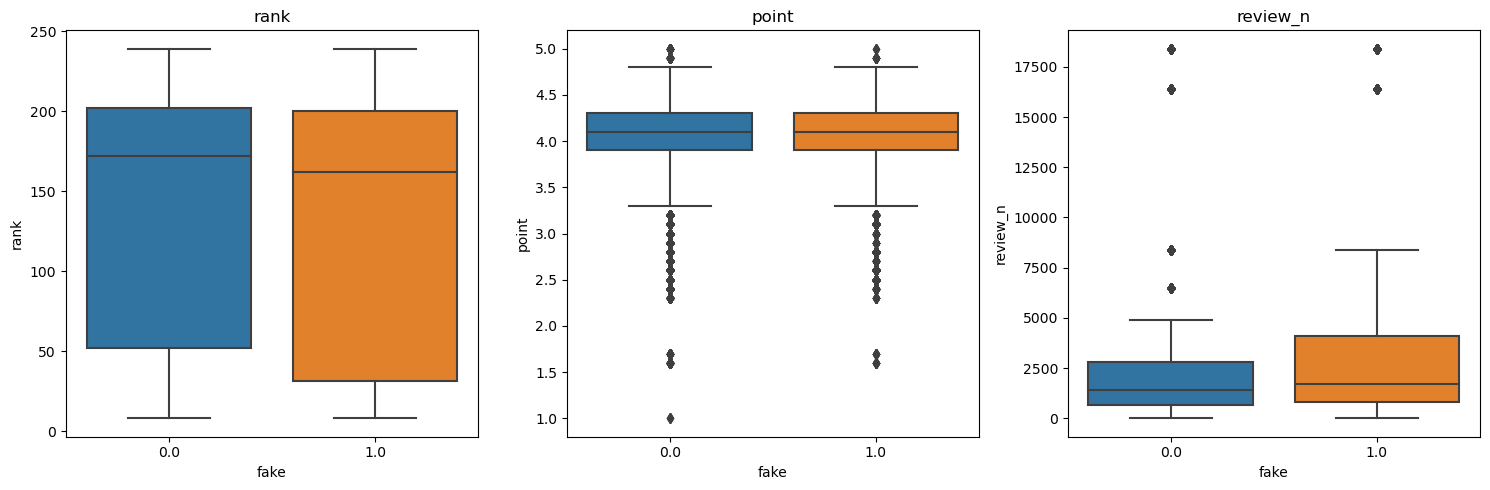

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建一个包含两个子图的画布，以显示两个组的箱线图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 绘制'a'变量的箱线图
sns.boxplot(x='fake', y='rank', data=restaurant, ax=axes[0])
axes[0].set_title('rank')

# 绘制'b'变量的箱线图
sns.boxplot(x='fake', y='point', data=restaurant, ax=axes[1])
axes[1].set_title('point')

# 绘制'c'变量的箱线图
sns.boxplot(x='fake', y='review_n', data=restaurant, ax=axes[2])
axes[2].set_title('review_n')

# 显示图形
plt.tight_layout()
plt.show()

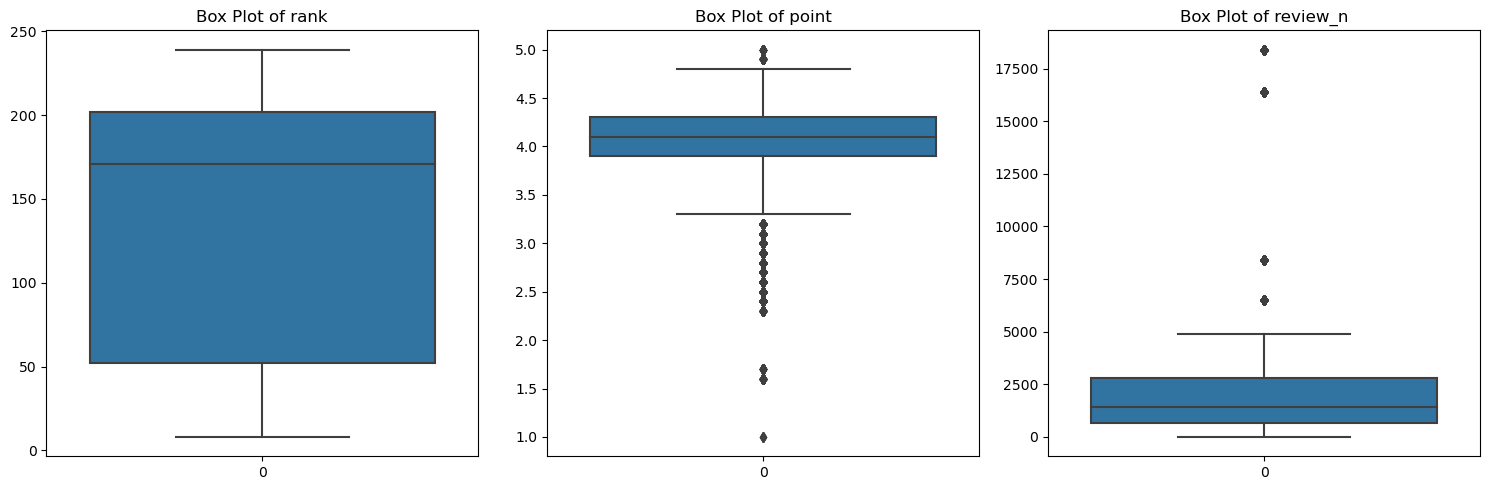

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选择要绘制箱线图的三个变量
variables =['rank', 'point', 'review_n']

# 创建一个包含三个子图的画布，以显示三个变量的箱线图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 使用seaborn的boxplot函数绘制每个变量的箱线图
for i, variable in enumerate(variables):
    sns.boxplot(data= restaurant[variable], ax=axes[i])
    axes[i].set_title(f'Box Plot of {variable}')

# 显示图形
plt.tight_layout()
plt.show()

In [48]:
description =yelp.describe()
display(description)

,rank,point,review_n,has_profile,friend,review,photo,rating,fake,local,compound,positive,negative,neutral,word_count,sentence_length,adj_POS,I_pronoun,past_tense,rating_dev
count,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000,486756.000000
mean,143.747537,4.031845,2937.456167,0.724768,114.982299,124.793864,247.505888,4.032947,0.099239,0.183879,0.729974,0.224259,0.034446,0.741290,96.170167,8.168460,0.113737,0.033297,0.022981,0.000098
std,77.080144,0.364731,4375.892896,0.446632,300.222275,399.568578,2124.002076,1.243760,0.298982,0.387386,0.454630,0.130237,0.049879,0.119064,94.559988,7.465439,0.056699,0.030853,0.022768,0.877618
min,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.998700,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-23.522727
25%,49.000000,3.900000,686.000000,0.000000,0.000000,8.000000,0.000000,4.000000,0.000000,0.000000,0.757400,0.134000,0.000000,0.681000,34.000000,4.000000,0.080000,0.000000,0.000000,-0.403112
50%,170.000000,4.100000,1400.000000,1.000000,13.000000,28.000000,4.000000,4.000000,0.000000,0.000000,0.924300,0.205000,0.018000,0.760000,66.000000,6.000000,0.105263,0.029412,0.020408,0.404627
75%,201.000000,4.300000,2900.000000,1.000000,114.000000,101.000000,43.000000,5.000000,0.000000,0.000000,0.972500,0.293000,0.052000,0.822000,125.000000,10.000000,0.137255,0.051282,0.036765,0.649476
max,239.000000,5.000000,18400.000000,1.000000,5000.000000,20415.000000,157513.000000,5.000000,1.000000,1.000000,0.999800,1.000000,1.000000,1.000000,1728.000000,431.000000,1.000000,1.000000,0.500000,4.128571


In [35]:
target_value = 157513
target_individuals = user[user['photo'] == target_value]

table = target_individuals.head()
display(table)

,username,location,has_profile,friend,review,photo,rating,rating_dev,local,fake
421498,Michael U.,"Las Vegas, NV",1.0,3564.0,5437.0,157513.0,1.0,-2.597052,0.0,0.0
480835,Michael U.,"Las Vegas, NV",1.0,3564.0,5437.0,157513.0,5.0,0.672928,0.0,0.0


In [36]:
target_value = 20415
target_individuals = user[user['review'] == target_value]

table = target_individuals.head()
display(table)

,username,location,has_profile,friend,review,photo,rating,rating_dev,local,fake
262558,Bruce K.,"Charlotte, NC",1.0,2122.0,20415.0,52350.0,4.0,0.066823,0.0,0.0


In [37]:
target_value = 5000
target_individuals = user[user['friend'] == target_value]

table = target_individuals.head()
display(table)

,username,location,has_profile,friend,review,photo,rating,rating_dev,local,fake
394,Christine R.,"Marin County, CA",1.0,5000.0,1494.0,32653.0,5.0,0.843328,0.0,0.0
3369,Casey S.,"Alameda, CA",1.0,5000.0,1929.0,1267.0,4.0,-0.082238,1.0,0.0
9941,Casey S.,"Alameda, CA",1.0,5000.0,1929.0,1267.0,4.0,0.061930,1.0,0.0
12577,Casey S.,"Alameda, CA",1.0,5000.0,1929.0,1267.0,4.0,0.146430,1.0,0.0
13445,Casey S.,"Alameda, CA",1.0,5000.0,1929.0,1267.0,4.0,-0.381212,1.0,0.0


ValueError: 'label' must be of length 'x'

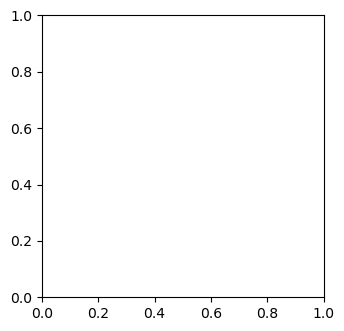

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 分别筛选推荐评论和非推荐评论的数据
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 获取所有评分的唯一值
unique_ratings = user['rating'].unique()

# 设置颜色循环，确保相同评分值具有相同的颜色
colors = plt.cm.Paired(range(len(unique_ratings)))

# 绘制推荐评论的饼状图
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.gca().set_prop_cycle('color', colors)
plt.pie(recommend_reviews['rating'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Fake=0 rating')

# 绘制非推荐评论的饼状图
plt.subplot(122)
plt.gca().set_prop_cycle('color', colors)
plt.pie(non_recommend_reviews['rating'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Fake=1 rating')

plt.tight_layout()
plt.show()

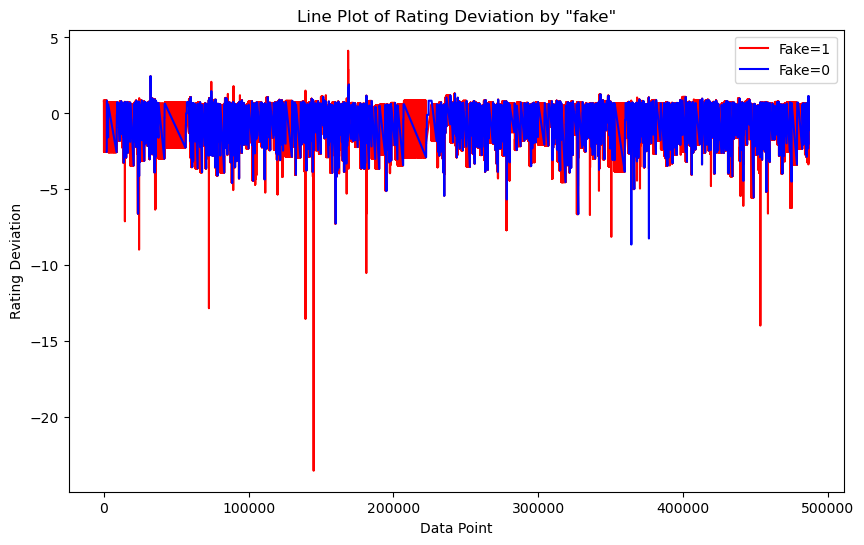

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据存储在名为 "user" 的数据帧中

# 根据'fake'变量分割数据
fake_1_data = user[user['fake'] == 1]
fake_0_data = user[user['fake'] == 0]

# 创建一个画布
plt.figure(figsize=(10, 6))

# 绘制fake=1的折线
plt.plot(fake_0_data['rating_dev'], label='Fake=1', color='r')

# 绘制fake=0的折线
plt.plot(fake_1_data['rating_dev'], label='Fake=0', color='b')

plt.title('Line Plot of Rating Deviation by "fake"')
plt.xlabel('Data Point')
plt.ylabel('Rating Deviation')
plt.legend()

# 显示图形
plt.show()

In [20]:
user['has_profile'].value_counts()

1.0    350221
0.0    132614
Name: has_profile, dtype: int64

In [31]:
import pandas as pd

# 假设您的数据存储在名为 "user" 的数据帧中

# 使用pandas的replace函数将变量'has_profile'的取值对调
user['has_profile'] = user['has_profile'].replace({0: 1, 1: 0})

C:\Users\10047\AppData\Local\Temp\ipykernel_7552\3891347853.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user['has_profile'] = user['has_profile'].replace({0: 1, 1: 0})


ValueError: 'label' must be of length 'x'

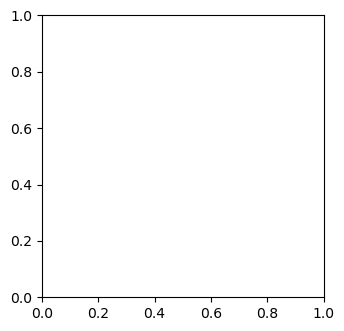

In [47]:
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 获取所有评分的唯一值
unique_ratings = user['has_profile'].unique()

# 设置颜色循环，确保相同评分值具有相同的颜色
colors = plt.cm.Paired(range(len(unique_ratings)))

# 绘制推荐评论的饼状图
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.gca().set_prop_cycle('color', colors)
plt.pie(recommend_reviews['has_profile'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Fake=0 has_profile')

# 绘制非推荐评论的饼状图
plt.subplot(122)
plt.gca().set_prop_cycle('color', colors)
plt.pie(non_recommend_reviews['has_profile'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Fake=1 has_profile')

plt.tight_layout()
plt.show()

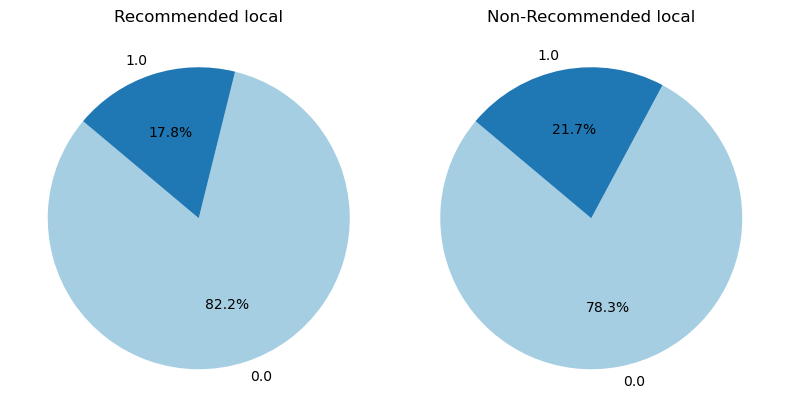

In [17]:
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 获取所有评分的唯一值
unique_ratings = user['local'].unique()

# 设置颜色循环，确保相同评分值具有相同的颜色
colors = plt.cm.Paired(range(len(unique_ratings)))

# 绘制推荐评论的饼状图
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.gca().set_prop_cycle('color', colors)
plt.pie(recommend_reviews['local'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Recommended local')

# 绘制非推荐评论的饼状图
plt.subplot(122)
plt.gca().set_prop_cycle('color', colors)
plt.pie(non_recommend_reviews['local'].value_counts(), labels=unique_ratings, autopct='%1.1f%%', startangle=140)
plt.title('Non-Recommended local')

plt.tight_layout()
plt.show()

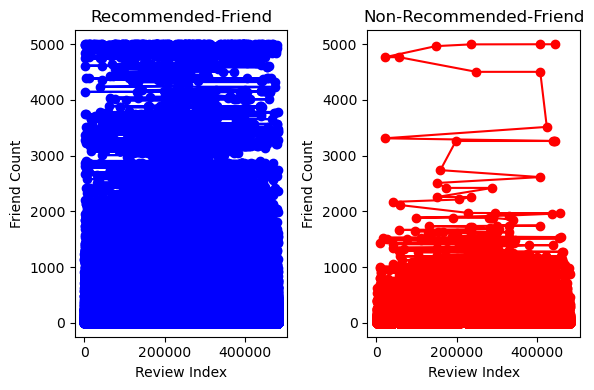

In [20]:
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 对每个数据集按照 'friend' 列降序排列
recommend_reviews = recommend_reviews.sort_values(by='friend', ascending=False)
non_recommend_reviews = non_recommend_reviews.sort_values(by='friend', ascending=False)

# 绘制推荐评论的折线图
plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.plot(recommend_reviews['friend'], marker='o', linestyle='-', color='b')
plt.title('Recommended-Friend')
plt.xlabel('Review Index')
plt.ylabel('Friend Count')

# 绘制非推荐评论的折线图
plt.subplot(122)
plt.plot(non_recommend_reviews['friend'], marker='o', linestyle='-', color='r')
plt.title('Non-Recommended-Friend')
plt.xlabel('Review Index')
plt.ylabel('Friend Count')

plt.tight_layout()
plt.show()

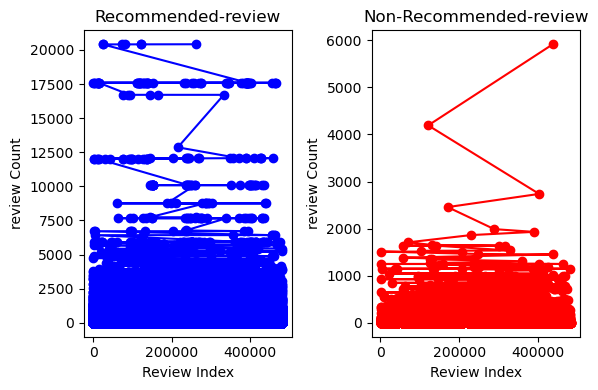

In [22]:
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 对每个数据集按照 'friend' 列降序排列
recommend_reviews = recommend_reviews.sort_values(by='review', ascending=False)
non_recommend_reviews = non_recommend_reviews.sort_values(by='review', ascending=False)

# 绘制推荐评论的折线图
plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.plot(recommend_reviews['review'], marker='o', linestyle='-', color='b')
plt.title('Recommended-review')
plt.xlabel('Review Index')
plt.ylabel('review Count')

# 绘制非推荐评论的折线图
plt.subplot(122)
plt.plot(non_recommend_reviews['review'], marker='o', linestyle='-', color='r')
plt.title('Non-Recommended-review')
plt.xlabel('Review Index')
plt.ylabel('review Count')

plt.tight_layout()
plt.show()

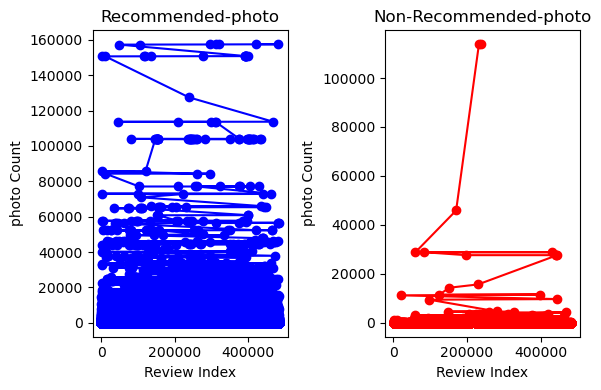

In [23]:
recommend_reviews = user[user['fake'] == 0]
non_recommend_reviews = user[user['fake'] == 1]

# 对每个数据集按照 'friend' 列降序排列
recommend_reviews = recommend_reviews.sort_values(by='photo', ascending=False)
non_recommend_reviews = non_recommend_reviews.sort_values(by='photo', ascending=False)

# 绘制推荐评论的折线图
plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.plot(recommend_reviews['photo'], marker='o', linestyle='-', color='b')
plt.title('Recommended-photo')
plt.xlabel('Review Index')
plt.ylabel('photo Count')

# 绘制非推荐评论的折线图
plt.subplot(122)
plt.plot(non_recommend_reviews['photo'], marker='o', linestyle='-', color='r')
plt.title('Non-Recommended-photo')
plt.xlabel('Review Index')
plt.ylabel('photo Count')

plt.tight_layout()
plt.show()

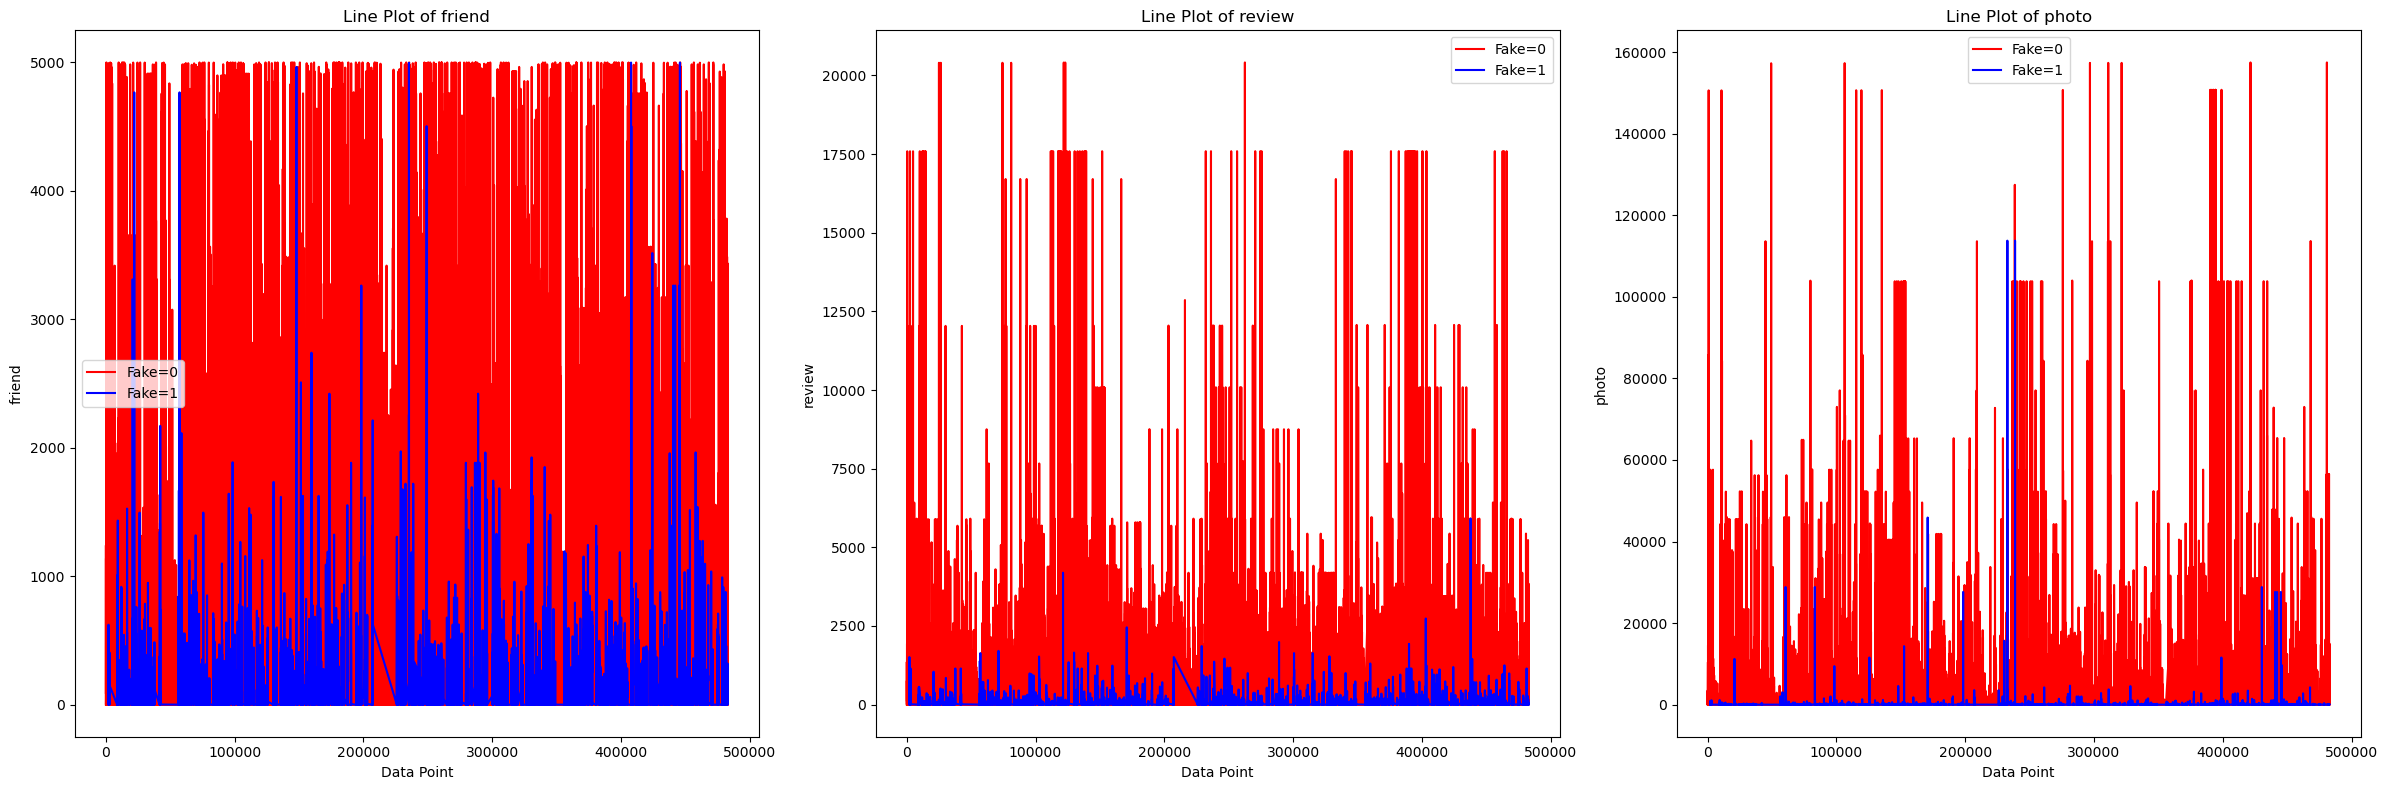

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据存储在名为 "user" 的数据帧中

# 根据'fake'变量分割数据
fake_1_data = user[user['fake'] == 1]
fake_0_data = user[user['fake'] == 0]

# 选择要绘制的变量
variables = ['friend', 'review', 'photo']

# 创建一个包含四个子图的画布
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

# 绘制折线图
for i, variable in enumerate(variables):
    # 绘制fake=1的折线
    axes[i].plot(fake_0_data[variable], label='Fake=0', color='r')
    # 绘制fake=0的折线
    axes[i].plot(fake_1_data[variable], label='Fake=1', color='b')
    axes[i].set_title(f'Line Plot of {variable}')
    axes[i].set_xlabel('Data Point')
    axes[i].set_ylabel(variable)
    axes[i].legend()

# 显示图形
plt.tight_layout()
plt.show()

In [50]:
description = reviews.describe()
display(description)

,compound,positive,negative,neutral,word_count,sentence_length,adj_POS,I_pronoun,past_tense
count,482835.000000,482835.000000,482835.000000,482835.000000,482835.000000,482835.000000,482835.000000,482835.000000,482835.000000
mean,0.730701,0.223161,0.034471,0.742364,96.688291,8.204179,9.718546,3.486292,2.651500
std,0.455038,0.128405,0.049553,0.117182,94.654489,7.475865,8.995449,4.651935,3.760276
min,-0.998700,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.759600,0.134000,0.000000,0.682000,34.000000,4.000000,4.000000,0.000000,0.000000
50%,0.924600,0.204000,0.018000,0.761000,66.000000,6.000000,7.000000,2.000000,1.000000
75%,0.972700,0.292000,0.052000,0.822000,125.000000,10.000000,13.000000,5.000000,4.000000
max,0.999800,1.000000,1.000000,1.000000,1728.000000,431.000000,129.000000,110.000000,61.000000


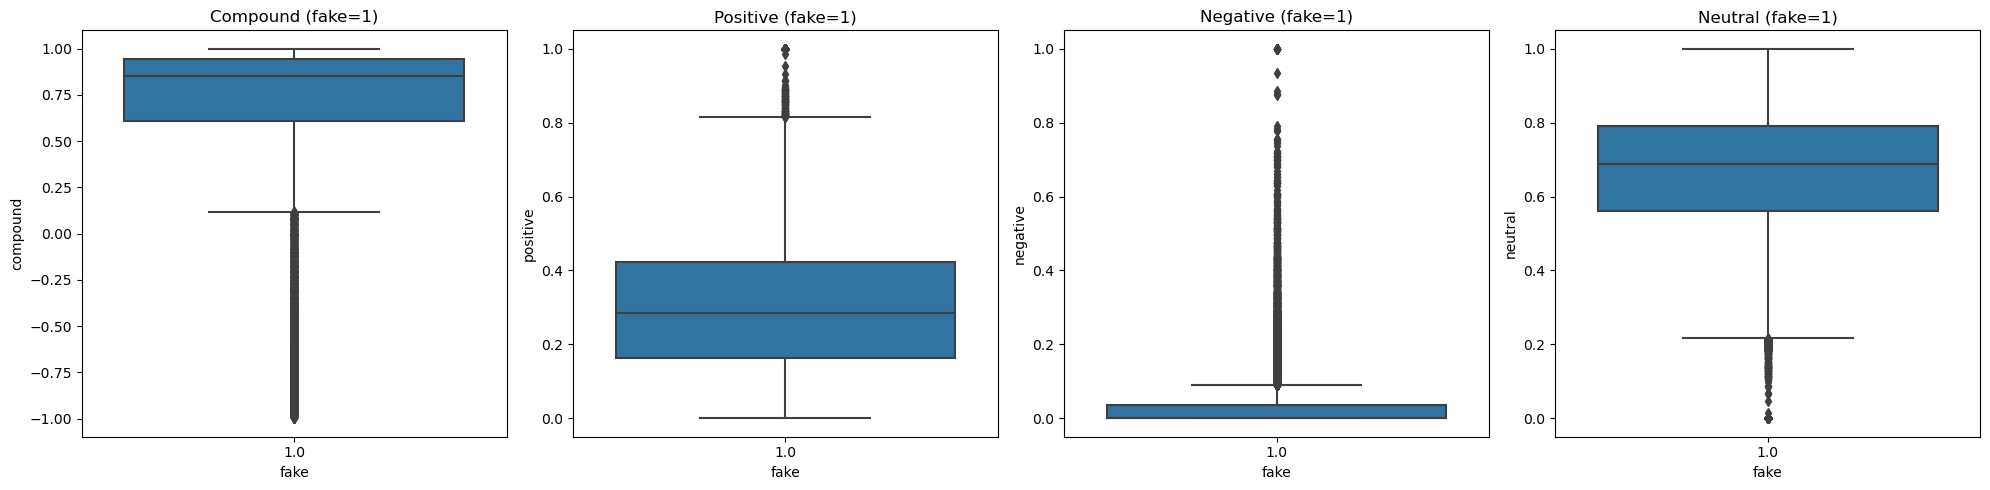

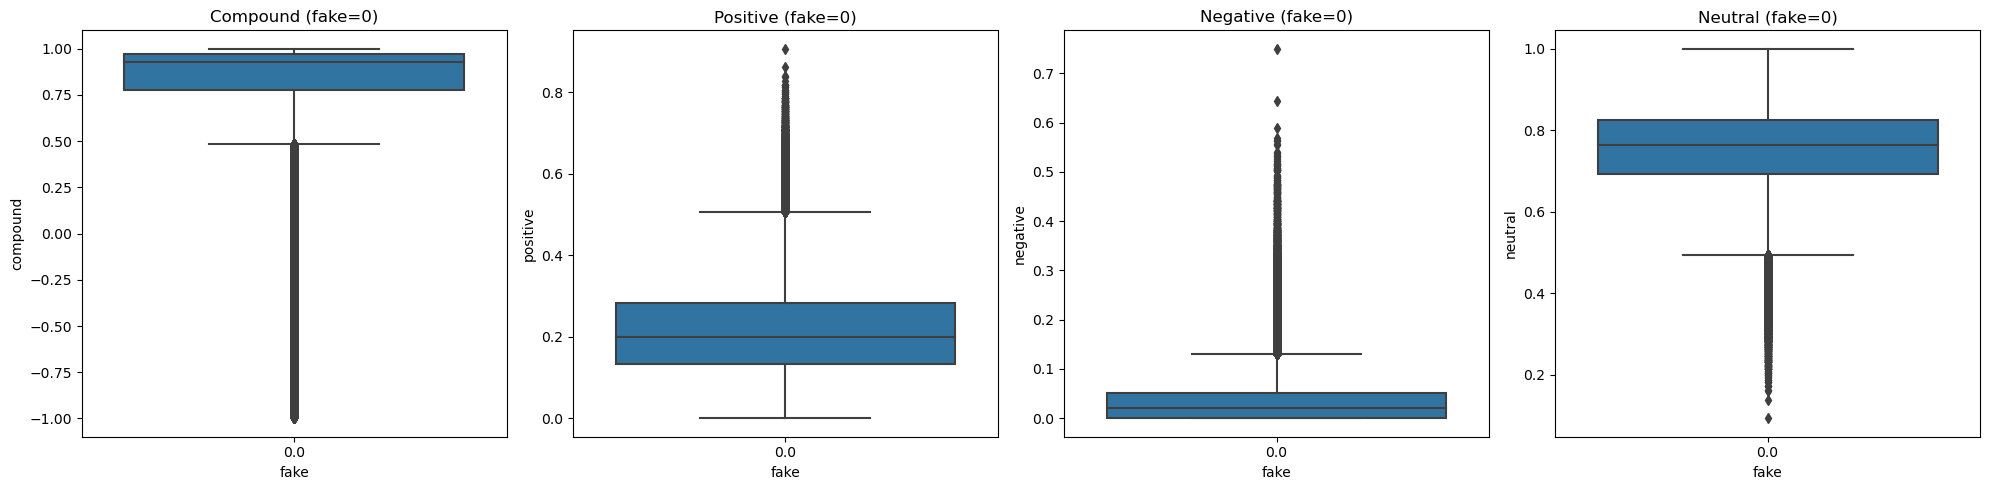

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设您的数据存储在名为 "restaurant" 的数据帧中

# 创建一个包含两个子图的画布，以显示两组的箱线图
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

# fake=1 的箱线图
sns.boxplot(x='fake', y='compound', data=reviews[reviews['fake'] == 1], ax=axes[0])
axes[0].set_title('Compound (fake=1)')

sns.boxplot(x='fake', y='positive', data=reviews[reviews['fake'] == 1], ax=axes[1])
axes[1].set_title('Positive (fake=1)')

sns.boxplot(x='fake', y='negative', data=reviews[reviews['fake'] == 1], ax=axes[2])
axes[2].set_title('Negative (fake=1)')

sns.boxplot(x='fake', y='neutral', data=reviews[reviews['fake'] == 1], ax=axes[3])
axes[3].set_title('Neutral (fake=1)')

# 显示图形
plt.tight_layout()
plt.show()

# 创建一个包含两个子图的画布，以显示两组的箱线图
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

# fake=0 的箱线图
sns.boxplot(x='fake', y='compound', data=reviews[reviews['fake'] == 0], ax=axes[0])
axes[0].set_title('Compound (fake=0)')

sns.boxplot(x='fake', y='positive', data=reviews[reviews['fake'] == 0], ax=axes[1])
axes[1].set_title('Positive (fake=0)')

sns.boxplot(x='fake', y='negative', data=reviews[reviews['fake'] == 0], ax=axes[2])
axes[2].set_title('Negative (fake=0)')

sns.boxplot(x='fake', y='neutral', data=reviews[reviews['fake'] == 0], ax=axes[3])
axes[3].set_title('Neutral (fake=0)')

# 显示图形
plt.tight_layout()
plt.show()

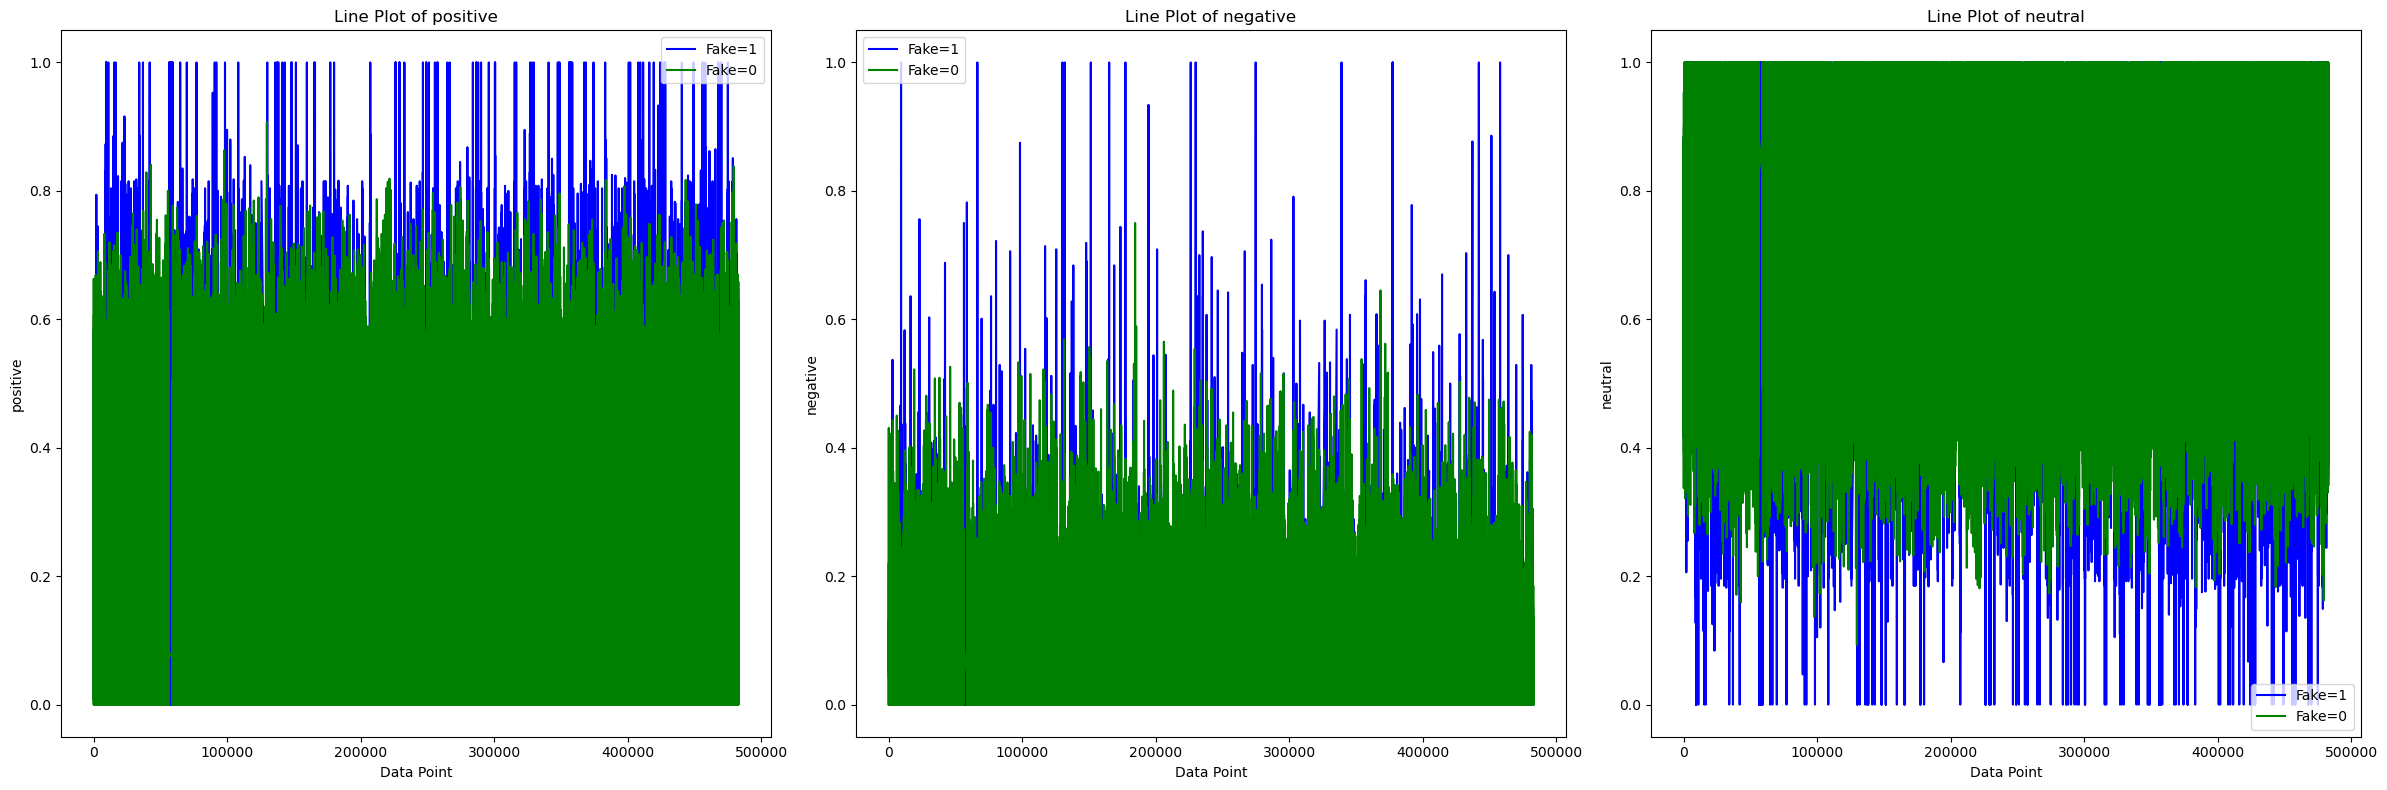

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据存储在名为 "user" 的数据帧中

# 根据'fake'变量分割数据
fake_1_data = reviews[reviews['fake'] == 1]
fake_0_data = reviews[reviews['fake'] == 0]

# 选择要绘制的变量
variables = ['positive', 'negative', 'neutral']

# 创建一个包含四个子图的画布
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

# 绘制折线图
for i, variable in enumerate(variables):
    # 绘制fake=1的折线
    axes[i].plot(fake_1_data[variable], label='Fake=1', color='b')
    # 绘制fake=0的折线
    axes[i].plot(fake_0_data[variable], label='Fake=0', color='g')
    axes[i].set_title(f'Line Plot of {variable}')
    axes[i].set_xlabel('Data Point')
    axes[i].set_ylabel(variable)
    axes[i].legend()

# 显示图形
plt.tight_layout()
plt.show()

C:\Users\10047\AppData\Local\Temp\ipykernel_8832\4191343114.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = reviews.groupby('fake').mean()


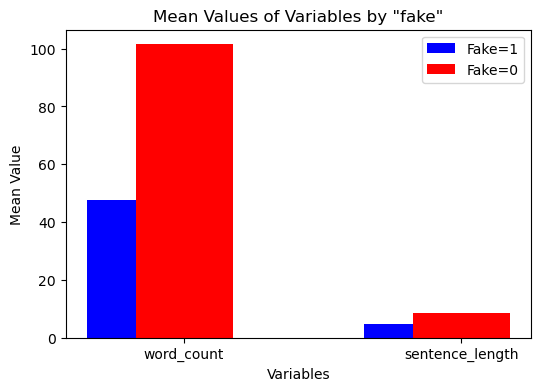

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据存储在名为 "reviews" 的数据帧中

# 根据'fake'变量分组并计算均值
grouped_data = reviews.groupby('fake').mean()

# 选择要绘制的变量
variables = ['word_count', 'sentence_length']

# 提取fake=1和fake=0的均值数据
fake_1_means = grouped_data.loc[1, variables]
fake_0_means = grouped_data.loc[0, variables]

# 创建条形图
plt.figure(figsize=(6,4))
bar_width = 0.35
index = range(len(variables))

plt.bar(index, fake_1_means, bar_width, label='Fake=1', color='b')
plt.bar(index, fake_0_means, bar_width, label='Fake=0', color='r', align='edge')

plt.xlabel('Variables')
plt.ylabel('Mean Value')
plt.title('Mean Values of Variables by "fake"')
plt.xticks([i + bar_width/2 for i in index], variables)
plt.legend()

# 显示图形
plt.show()

C:\Users\10047\AppData\Local\Temp\ipykernel_8832\2739370534.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = reviews.groupby('fake').mean()


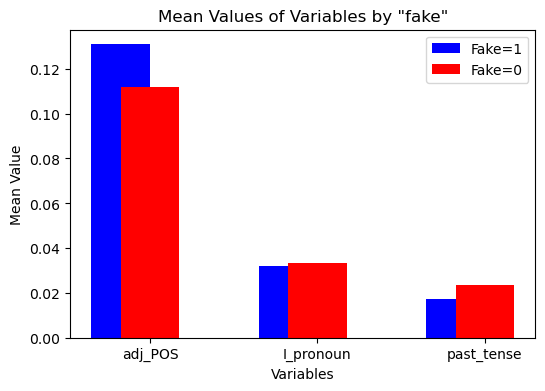

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据存储在名为 "reviews" 的数据帧中

# 根据'fake'变量分组并计算均值
grouped_data = reviews.groupby('fake').mean()

# 选择要绘制的变量
variables = ['adj_POS', 'I_pronoun', 'past_tense']

# 提取fake=1和fake=0的均值数据
fake_1_means = grouped_data.loc[1, variables]
fake_0_means = grouped_data.loc[0, variables]

# 创建条形图
plt.figure(figsize=(6,4))
bar_width = 0.35
index = range(len(variables))

plt.bar(index, fake_1_means, bar_width, label='Fake=1', color='b')
plt.bar(index, fake_0_means, bar_width, label='Fake=0', color='r', align='edge')

plt.xlabel('Variables')
plt.ylabel('Mean Value')
plt.title('Mean Values of Variables by "fake"')
plt.xticks([i + bar_width/2 for i in index], variables)
plt.legend()

# 显示图形
plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pandas as pd

# Assuming df is your DataFrame
# Replace 'your_data_frame' with the actual DataFrame containing your dataset
# Example: df = pd.read_csv('your_dataset.csv')

# Assume 'dependent_variable' is the column you want to predict, and 'independent_variable' is the predictor
X = yelp[['word_count', 'sentence_length', 'adj_POS', 'I_pronoun', 'past_tense']]
y = yelp['fake']

# Create a logistic regression model with sklearn
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

# Display the logistic regression coefficients
print("Logistic Regression Coefficients:")
print(logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)

# Create a logistic regression model with statsmodels
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the logistic regression results
print(result.summary())

Logistic Regression Coefficients:
[[-0.01206419 -0.04365497  1.43593922  2.1333641  -4.13978723]]
Intercept: [-1.30119804]
Optimization terminated successfully.
         Current function value: 0.295406
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   fake   No. Observations:               486756
Model:                          Logit   Df Residuals:                   486750
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                 0.08658
Time:                        15:08:44   Log-Likelihood:            -1.4379e+05
converged:                       True   LL-Null:                   -1.5742e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [62]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pandas as pd

# Assuming df is your DataFrame
# Replace 'your_data_frame' with the actual DataFrame containing your dataset
# Example: df = pd.read_csv('your_dataset.csv')

# Assume 'fake' is the column you want to predict
X = yelp[['rank', 'point', 'review_n',  'has_profile', 'friend', 'review', 'photo',
       'rating',  'local', 'positive', 'negative',
       'neutral', 'word_count', 'sentence_length', 'adj_POS', 'I_pronoun',
       'past_tense', 'rating_dev']]
y = yelp['fake']

# Create a logistic regression model with sklearn
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

# Display the logistic regression coefficients
print("Logistic Regression Coefficients:")
print(logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)

# Create a logistic regression model with statsmodels
X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the logistic regression results
print(result.summary())

C:\Users\10047\Anaconda3\envs\new\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Coefficients:
[[-1.03285391e-03 -7.67168253e-02  4.07186627e-05 -2.00942968e-02
  -1.57785361e-03 -1.23169011e-02  1.11372688e-04 -8.06257473e-02
   2.60805702e-03  7.36957399e-04 -6.00805242e-04 -1.71463604e-02
  -9.06955212e-03 -5.59047857e-02 -1.36638509e-03 -1.39496291e-04
  -6.83753411e-04 -5.15382460e-03]]
Intercept: [-0.01700528]
Optimization terminated successfully.
         Current function value: 0.268710
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                   fake   No. Observations:               486756
Model:                          Logit   Df Residuals:                   486737
Method:                           MLE   Df Model:                           18
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                  0.1691
Time:                        15:17:52   Log-Likelihood:            -1.3080e+05
converged:                       True   LL-Null:                